<a href="https://colab.research.google.com/github/spyrosmi/cellxgene_census_macropahes_fibroblasts_tutorial/blob/main/fibroblasts_scvi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -U cellxgene-census #install cellxgene_census

In [ ]:
!pip install anndata==0.9.2
import locale
locale.getprefferednecoding= lambda:"UTF-8"
!pip install scanpy scikit-misc scvi-tools seaborn
import scanpy as sc
import scvi
import skmisc
import numpy as np
import seaborn as sns
!pip install leidenalg
import leidenalg

In [2]:
import cellxgene_census #download the datasets

with cellxgene_census.open_soma() as census:
    adata = cellxgene_census.get_anndata(
        census = census,
        organism = "Mus musculus",
        obs_value_filter = "is_primary_data == True and cell_type in ['fibroblast of cardiac tissue', 'fibroblast of connective tissue of prostate', 'fibroblast of lung', 'fibroblast', 'kidney interstitial fibroblast', 'pulmonary interstitial fibroblast']")

    print(adata)

The "stable" release is currently 2023-12-15. Specify 'census_version="2023-12-15"' in future calls to open_soma() to ensure data consistency.
INFO:cellxgene_census:The "stable" release is currently 2023-12-15. Specify 'census_version="2023-12-15"' in future calls to open_soma() to ensure data consistency.


AnnData object with n_obs × n_vars = 24509 × 52417
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'


In [3]:
adata.var.set_index("feature_name", inplace=True) #set gene names as the index of adata.var

In [4]:
adata=adata[adata.obs.assay.str.contains("10x")] #filter the data to include only data generated via 10X protocols

<ipython-input-6-c979b779b421>:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["mt"]=adata.var_names.str.startswith("Mt", "mt")


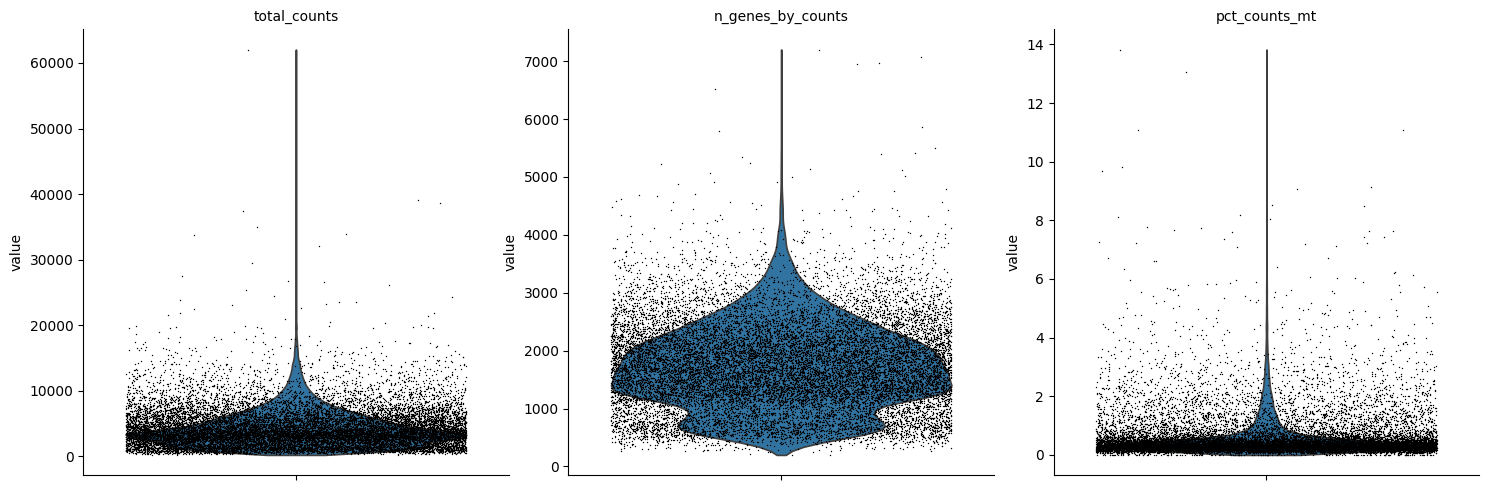

In [6]:
adata.var["mt"]=adata.var_names.str.startswith("Mt", "mt")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=False, inplace=True, log1p=False)
sc.pl.violin(adata, ["total_counts", "n_genes_by_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True) #perform quality control to calculate pct_counts_mt, n_genes_by_counts and total_counts

In [7]:
sc.pp.filter_genes(adata, min_cells=10) #remove low quality genes
sc.pp.filter_cells(adata, min_genes=200) #filter out low quality cells

In [8]:
upper_lim=np.quantile(adata.obs.n_genes_by_counts, .99)
upper_lim

3675.5199999999895

In [9]:
adata=adata[adata.obs.n_genes_by_counts < upper_lim]
adata=adata[adata.obs.pct_counts_mt < 2] # define pct_counts_mt threshold
adata

View of AnnData object with n_obs × n_vars = 17193 × 20549
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'soma_joinid', 'feature_id', 'feature_length', 'nnz', 'n_measured_obs', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [10]:
adata.layers["counts"]=adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw=adata # freeze data before selecting only highly variable genes

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


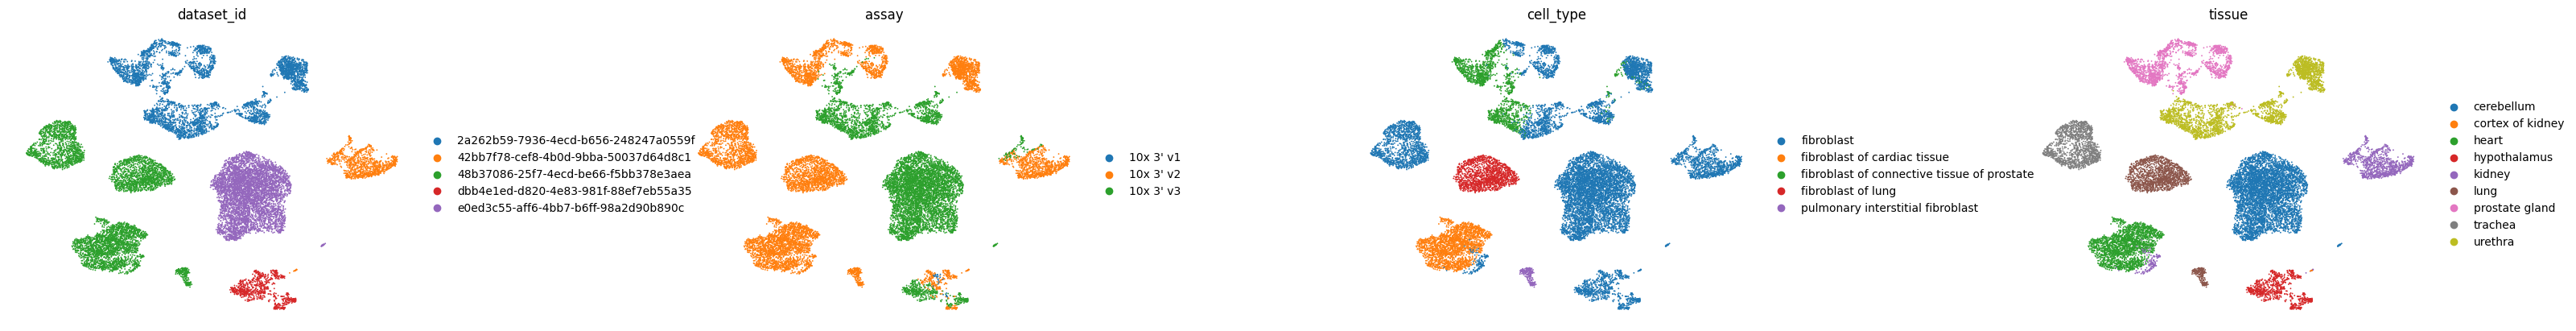

In [12]:
sc.pp.highly_variable_genes(adata, n_top_genes=8000)
data=adata[:,adata.var["highly_variable"]].copy()
sc.tl.pca(data, svd_solver="arpack")
sc.pp.neighbors(data, n_pcs=30)
sc.tl.umap(data)
sc.tl.leiden(data, resolution=1.0, key_added="no_scvi")
sc.pl.umap(data, color=["dataset_id", "assay", "cell_type", "tissue"], wspace=0.5, frameon=False) #check for batch effects prior to scVI. Here, the cells clustered primarily by dataset_id.

In [13]:
adata.obs["batch"]=adata.obs["dataset_id"].astype("str")+ adata.obs["assay_ontology_term_id"].astype("str") + adata.obs["donor_id"].astype("str") + adata.obs["suspension_type"].astype("str") #define batch_key for scVI

In [17]:
m=adata.obs["batch"].value_counts()

In [20]:
valid=m[m>10].index

In [21]:
adata.obs.batch.value_counts() #some combinations of batch_key are repeated less than 3 times. Remove all combinations appearing less than 10 times to allow scVI function properly

e0ed3c55-aff6-4bb7-b6ff-98a2d90b890cEFO:0009922M006nucleus               1792
48b37086-25f7-4ecd-be66-f5bb378e3aeaEFO:00098993-M-7/8cell               1648
2a262b59-7936-4ecd-b656-248247a0559fEFO:0009922musAd015cell              1318
2a262b59-7936-4ecd-b656-248247a0559fEFO:0009899musAd002cell              1294
e0ed3c55-aff6-4bb7-b6ff-98a2d90b890cEFO:0009922M002nucleus               1124
48b37086-25f7-4ecd-be66-f5bb378e3aeaEFO:00098993-M-5/6cell                979
e0ed3c55-aff6-4bb7-b6ff-98a2d90b890cEFO:0009922F002nucleus                948
42bb7f78-cef8-4b0d-9bba-50037d64d8c1EFO:0009899poolednucleus              946
48b37086-25f7-4ecd-be66-f5bb378e3aeaEFO:000989930-M-2cell                 936
e0ed3c55-aff6-4bb7-b6ff-98a2d90b890cEFO:0009922M001nucleus                923
2a262b59-7936-4ecd-b656-248247a0559fEFO:0009899musAd003cell               879
2a262b59-7936-4ecd-b656-248247a0559fEFO:0009922musAd004, musAd005cell     473
e0ed3c55-aff6-4bb7-b6ff-98a2d90b890cEFO:0009922F001nucleus      

In [22]:
adata=adata[adata.obs.batch.isin(valid)]

In [ ]:
sc.pp.highly_variable_genes(adata, n_top_genes=8000, flavor="seurat_v3", layer="counts", batch_key="batch", subset=True, span=1) #select highly variable genes from raw data

In [24]:
adata

AnnData object with n_obs × n_vars = 17160 × 8000
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'batch'
    var: 'soma_joinid', 'feature_id', 'feature_length', 'nnz', 'n_measured_obs', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_rank', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 

In [25]:
adata=adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="donor_id")
model=scvi.model.SCVI(adata, n_layers=5, n_latent=30, n_hidden=50, gene_likelihood="nb")
model.train() #train scVI model to remove technical noise from the datasets

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [13:49<00:00,  1.84s/it, v_num=1, train_loss_step=2.91e+3, train_loss_epoch=3.08e+3]

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [13:49<00:00,  2.07s/it, v_num=1, train_loss_step=2.91e+3, train_loss_epoch=3.08e+3]


In [26]:
latent=model.get_latent_representation()
adata.obsm["X_scVI"]=latent #extract latent representation of the data

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


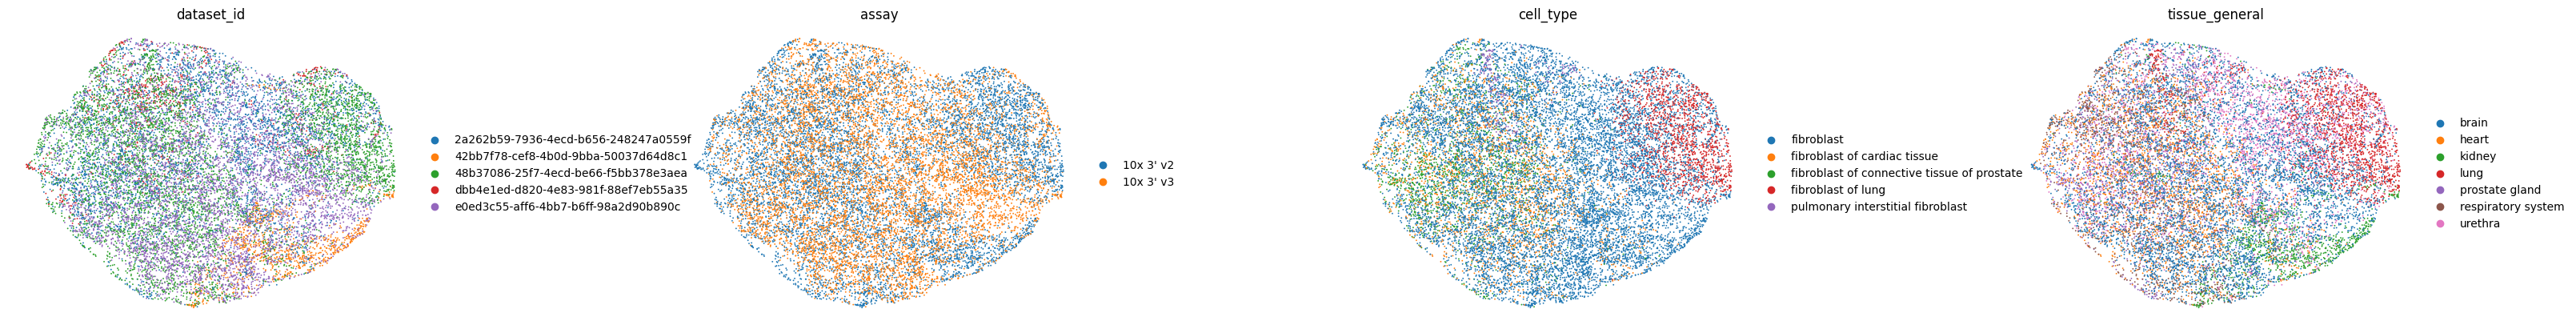

In [27]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="scvi", resolution=0.5)
sc.pl.umap(adata, color=["dataset_id", "assay", "cell_type", "tissue_general"], wspace=0.5, frameon=False) # 100

         Falling back to preprocessing with `sc.pp.pca` and default params.


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


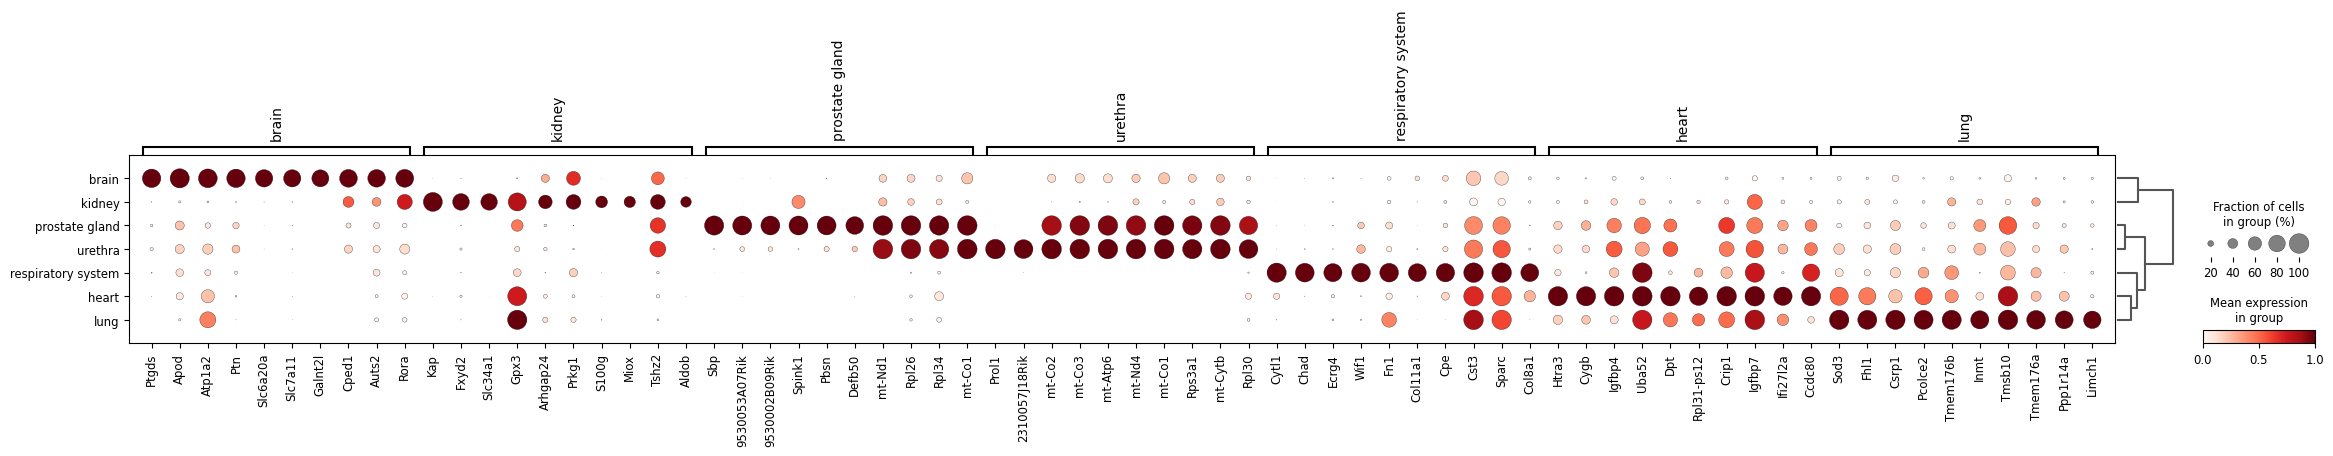

In [28]:
sc.tl.rank_genes_groups(adata, method="wilcoxon", key_added="genes", groupby="tissue_general",)
sc.pl.rank_genes_groups_dotplot(adata, key="genes", n_genes=10, groupby="tissue_general", standard_scale="var") # visualize 10 highly variable genes per tissue. In case ribosomal and mtochondrial genes are still present, adjustment can be bone to the data by defining new thresholds

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


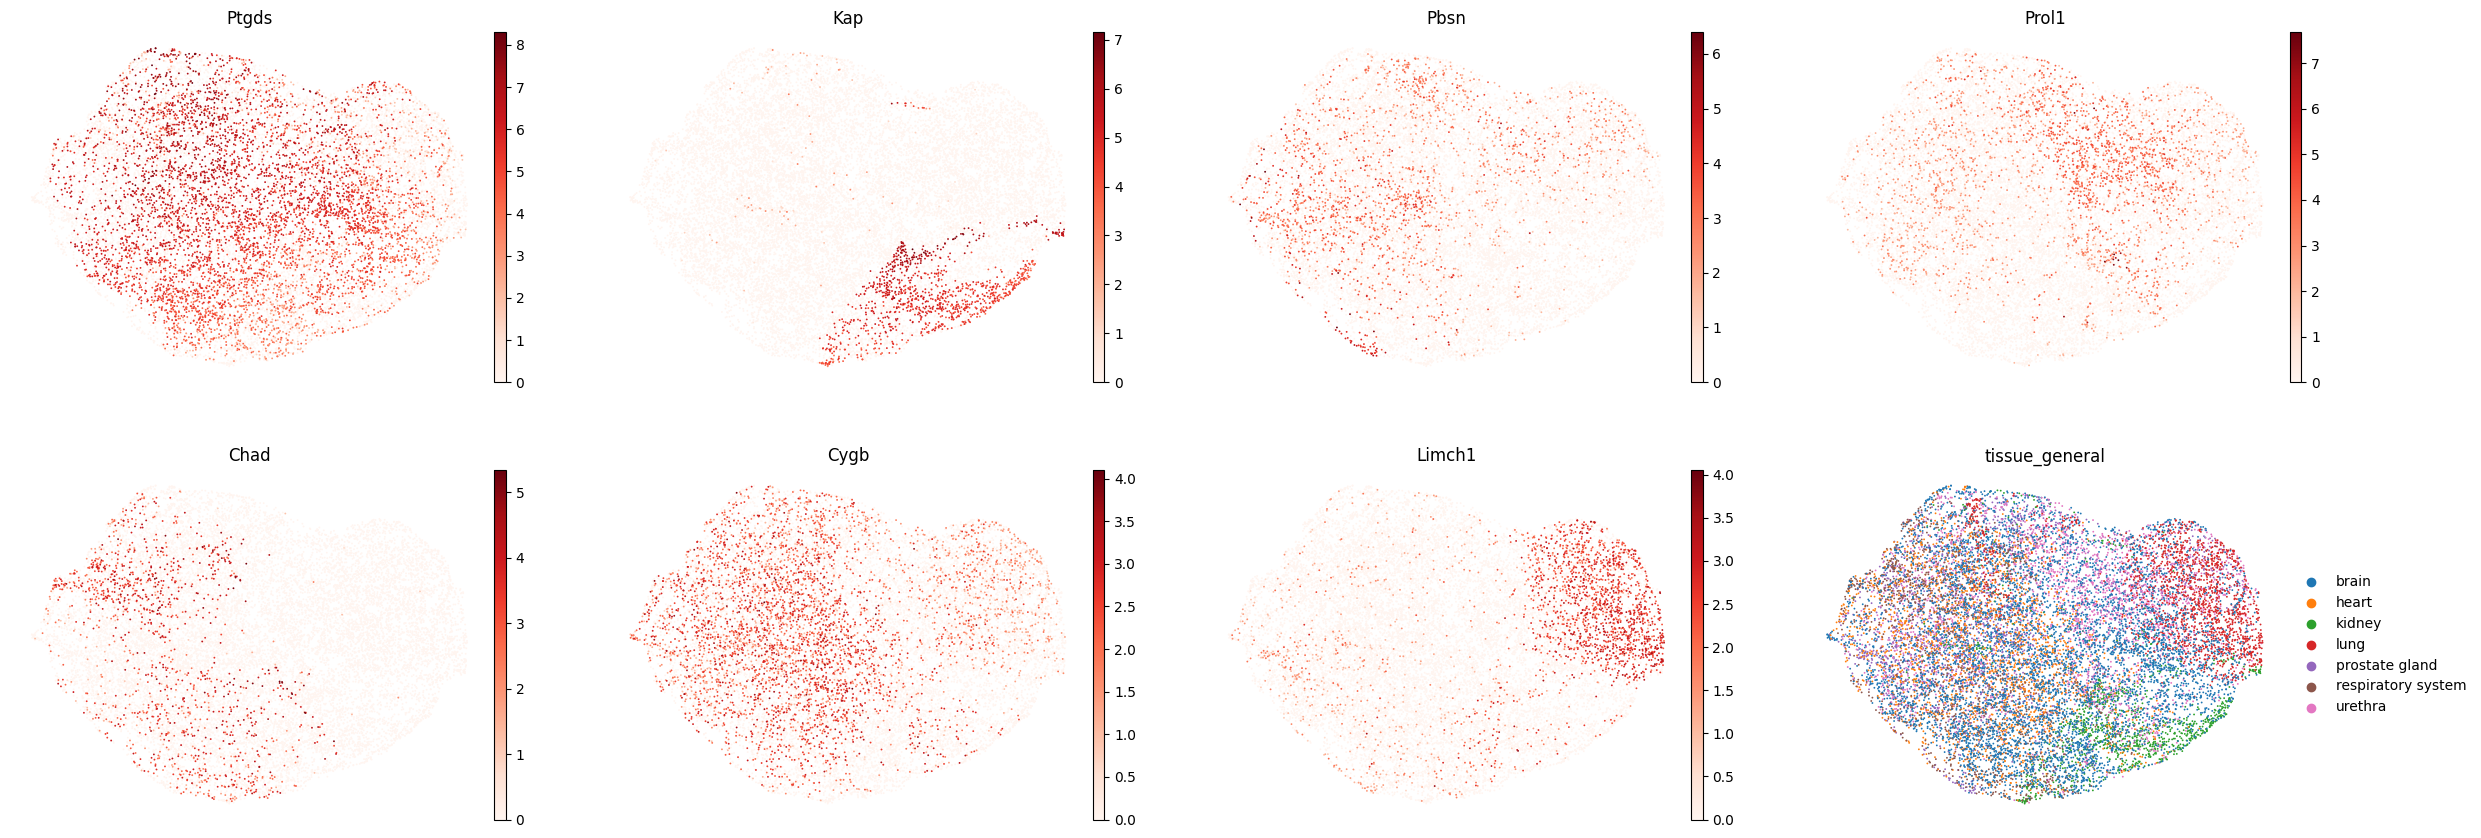

In [30]:
sc.pl.umap(adata, color=["Ptgds", "Kap", "Pbsn", "Prol1", "Chad", "Cygb", "Limch1", "tissue_general"], cmap="Reds", frameon=False)